<a href="https://colab.research.google.com/github/hachteja/CNMF-PS/blob/main/CNMF_Pan_Sharpening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNMF Pan-Sharpening
## A notebook for enhanced analysis of hyperspectral STEM-EELS datasets
## 08.03.21
## Notebook created by Jordan A. Hachtel and Nikolay S. Borodinov

Here, we use combined non-negative matrix factorization (CNMFS) pan-sharpening (PS) to combine two hyperspectral datasets, one with high spatial resolution (HSR) and one with high spectral fidelity (HSF), to gain a single dataset with the beneficial properties of both.

Included with this notebook is a link to sample data used in the published paper concerning this technique (link to come). These datasets are acquired using monochromated electron energy-loss spectroscopy (EELS) in the scanning transmission electron microscope (STEM). The samples are plasmonic assemblies of fluorine and tin doped indium oxide (FT:IO) nanoparticles. 

For any questions concerning this code, please address correspondence to hachtelja@ornl.gov. 

In [1]:
#@title Import Libraries

import numpy as np
import json
import copy
import math
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from scipy import interpolate
from sklearn.decomposition import NMF
from skimage.transform import resize
from matplotlib.patches import Rectangle
from pylab import cm

# **Important Note**

#### You must preprocess your data on your own, I previously tried to incorporate a generalized preprocessing that failed for too many different types of data. 

#### The data itself must be preprocessed so that any ZLP drift is corrected and that the zero-levels of the dataset are correct. Also, matplotlib plots data by having a separate array for the energyloss axis that is generally not included in a standard export of the data to a text file. To generate the energy loss axis you need to find the dispersion and the energy offset of the dataset, and input them in the next cell. The code will create the calibrated energy loss axis from those values. 

#### **It is critical that the energy loss axes of the HSF and HSR dataset are identical. This means both the HSR and HSF datasets should be defined by the exact same dispersion and offset and that their spectral axis should have the exact same number of energy loss channels.**


In [2]:
#@title Load and Calibrate Datasets

# Download Sample Data from Google Drive

!gdown https://drive.google.com/uc?id=1WI6E5Pco8n4EByZmodq-_L0US_OdekwV
!gdown https://drive.google.com/uc?id=1d1aOogZJAjfJYJHDprwtzBDQp4c2J5vt

# Load datasets 
# Format: 3D numpy array (2 spatial, 1 spectral dimension)
HSF=np.load('/content/HSF_data_calibrated.npy')
HSR=np.load('/content/HSR_data_calibrated.npy')

# Input Energy Loss Axis Calibration Values (eV/channel and eV)
disp=0.0002050410082016403;offset=0.025

# Input Spatial Calibration (nm/pixel)
HSF_cal=14.628571428571428
HSR_cal=3.4133333333333336

# Generate Calibrated Energy Loss Axes
E_HSF=np.arange(HSF.shape[2])*disp-offset
E_HSR=np.arange(HSF.shape[2])*disp-offset

# Check if calibrations are identical.
if (E_HSF==E_HSR).all(): 
    E=np.copy(E_HSF)
    print('Identical, please proceed with notebook')
else: print('Non-Identical, re-process datasets to get identical energy loss axes')


Downloading...
From: https://drive.google.com/uc?id=1WI6E5Pco8n4EByZmodq-_L0US_OdekwV
To: /content/HSR_data_calibrated.npy
900MB [00:06, 143MB/s]
Downloading...
From: https://drive.google.com/uc?id=1d1aOogZJAjfJYJHDprwtzBDQp4c2J5vt
To: /content/HSF_data_calibrated.npy
49.0MB [00:00, 105MB/s] 
Identical, please proceed with notebook


In [3]:
print(E.shape)

(5000,)


# **Important Note**

#### For low-loss datasets, the ZLP must be removed in order to do NMF decompositions. Here, we simply cutoff the pixels, but this could be accomplished with more rigourous ZLP removal techniques. If you have already preprocessed your data to remove the ZLP or the ZLP was not in the dataset to begin with simply skip the next cell.

In [4]:
#@title Prepare Datasets for CNMF-PS

# Select cutoff energy
E_cut=0.2
i_cut=np.argmin(np.abs(E-E_cut))

# Create final datasets for PS process
E=E[i_cut:]
HSF=HSF[:,:,i_cut:]
HSR=HSR[:,:,i_cut:]

In [5]:
#@title Perform HSF Decomposition

#Define shapes of HSF and HSR datasets
HSFdim=HSF.shape
HSRdim=HSR.shape

# Choose number of components for CNMF Reconstruction
ncomp=9

# Perform NMF decomposition
HSF_NMF=copy.deepcopy(HSF)
HSF_NMF[HSF_NMF<0]=0
HSF_NMF_flat=HSF_NMF.reshape(np.prod(HSFdim[:2]),HSFdim[2])
HSF_model=NMF(ncomp,max_iter=10000)
HSF_maps=HSF_model.fit_transform(HSF_NMF_flat).reshape(HSFdim[:2]+(ncomp,))
HSF_endmembers=HSF_model.components_

# Resize HSF_maps to the same dimensions as HSR acquisition
HSF_maps_HSR=resize(HSF_maps,HSRdim[:2]+(ncomp,)).reshape(np.prod(HSRdim[:2]),ncomp)

In [6]:
print(HSFdim)

(35, 35, 3903)


In [7]:
#@title Perform HSR Decomposition (Note: Only for comparison, not used in CNMF process)

HSR_NMF=copy.deepcopy(HSR)
HSR_NMF[HSR_NMF<0]=0
HSR_NMF_flat=HSR_NMF.reshape(np.prod(HSRdim[:2]),HSRdim[2])
HSR_model=NMF(ncomp,max_iter=10000)
HSR_maps=HSR_model.fit_transform(HSR_NMF_flat).reshape(HSRdim[:2]+(ncomp,))
HSR_endmembers=HSR_model.components_

In [8]:
#@title Perform CNMF Pan-Sharpening of HSR Dataset

PS_NMF=copy.deepcopy(HSR)
PS_NMF[PS_NMF<0]=0
PS_NMF_flat=PS_NMF.reshape(np.prod(HSRdim[:2]),HSRdim[2])
PS_model=NMF(ncomp,init='custom',random_state=0,solver='mu',max_iter=10000)
PS_maps=PS_model.fit_transform(PS_NMF_flat,H=HSF_endmembers, W=HSF_maps_HSR).reshape(HSRdim[:2]+(ncomp,))
PS_endmembers=PS_model.components_

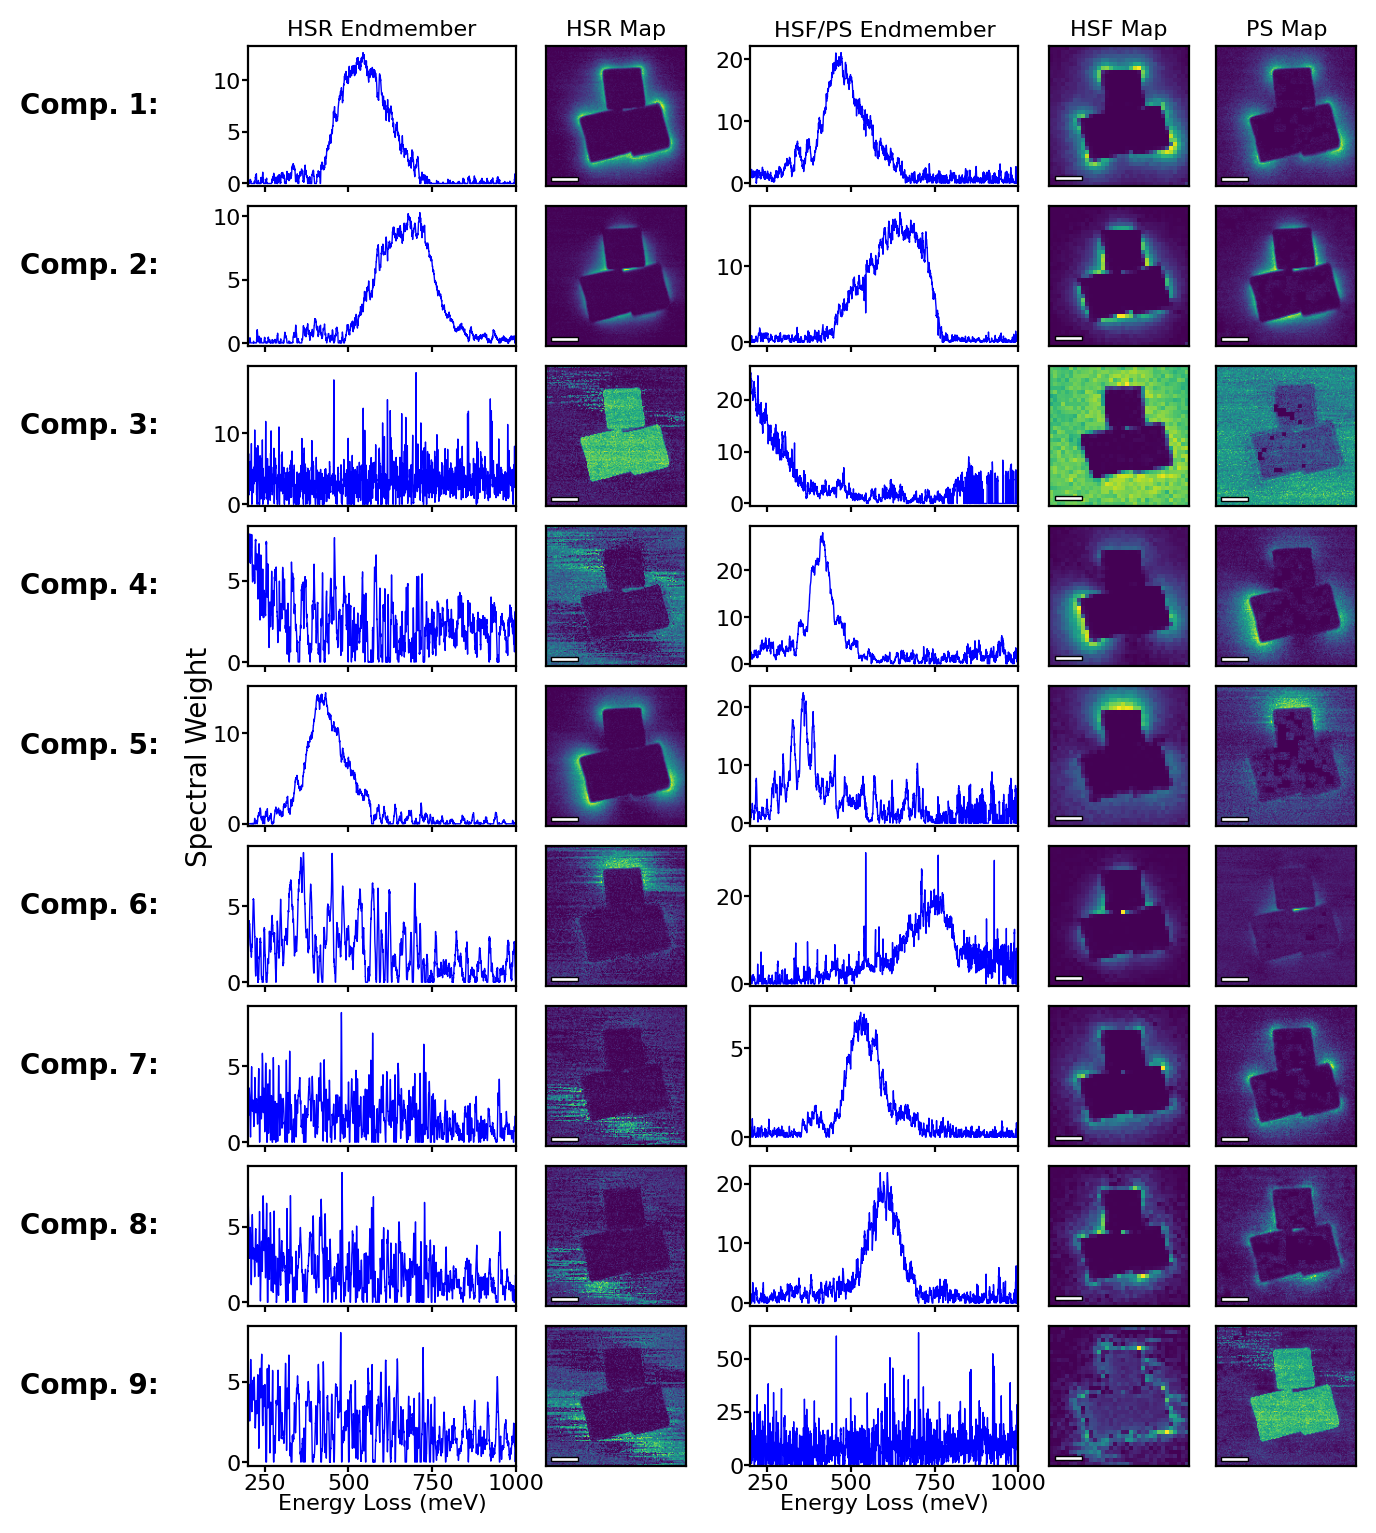

In [9]:
#@title Visualize: Individual Maps and Endmembers

fig=plt.figure(dpi=200,figsize=(6.7,0.8*ncomp))

for i in range(ncomp):
    #Plot HSR Endmembers
    ax=fig.add_axes([0.1,1-(i+1)/ncomp,0.2,0.875/ncomp])
    ax.plot(E*1000,HSR_endmembers[i],color='b',lw=0.5)
    ax.tick_params(labelsize=8,length=2,pad=0.5)
    ax.set_xlim(E[0]*1000,1000);ax.set_ylim(-0.25)
    if i==ncomp-1: ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=0)
    else: ax.set_xticklabels([])
    if i==4: ax.set_ylabel('Spectral Weight',fontsize=10,labelpad=0)
    if i==0: ax.set_title('HSR Endmember',fontsize=8,ha='center',va='center')

    #Plot HSR Abundance Maps
    ax=fig.add_axes([0.3,1-(i+1)/ncomp,0.15,0.875/ncomp],xticks=[],yticks=[])
    ax.imshow(HSR_maps[:,:,i],vmin=0)
    ax.add_patch(Rectangle((4,140),100/HSR_cal,4,fc='w',ec='k',lw=0.5))
    ax.text(-490,78,'Comp. '+str(i+1)+':',fontsize=10,ha='center',va='bottom',fontweight='bold')
    if i==0: ax.set_title('HSR Map',fontsize=8,ha='center',va='center')
    
    #Plot HSF and PS Endmembers
    ax=fig.add_axes([0.475,1-(i+1)/ncomp,0.2,0.875/ncomp])
    ax.plot(E*1000,HSF_endmembers[i],color='b',lw=0.5)
    ax.tick_params(labelsize=8,length=2,pad=0.5)
    ax.set_xlim(E[0]*1000,1000);ax.set_ylim(-0.5)
    if i==0: ax.set_title('HSF/PS Endmember',fontsize=8,ha='center',va='center')
    if i==ncomp-1: ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=0)
    else: ax.set_xticklabels([])
        
    #Plot HSF Abundance Maps
    ax=fig.add_axes([0.675,1-(i+1)/ncomp,0.15,0.875/ncomp],xticks=[],yticks=[])
    ax.imshow(HSF_maps[:,:,i],vmin=0)
    ax.add_patch(Rectangle((1,32),100/HSF_cal,1,fc='w',ec='k',lw=0.5))
    if i==0: ax.set_title('HSF Map',fontsize=8,ha='center',va='center')

    #Plot PS Abundance Maps
    ax=fig.add_axes([0.8,1-(i+1)/ncomp,0.15,0.875/ncomp],xticks=[],yticks=[])
    ax.imshow(PS_maps[:,:,i],vmin=0)
    ax.add_patch(Rectangle((4,140),100/HSR_cal,4,fc='w',ec='k',lw=0.5))     
    if i==0: ax.set_title('PS Map',fontsize=8,ha='center',va='center')

In [10]:
#@title Reconstruct Pan-sharpened dataset

PS=np.reshape(np.matmul(PS_maps,PS_endmembers),HSRdim)
PSmins=np.average(PS[:,:,-50:],axis=2)
PS=(PS.transpose(2,0,1)-PSmins).transpose(1,2,0)

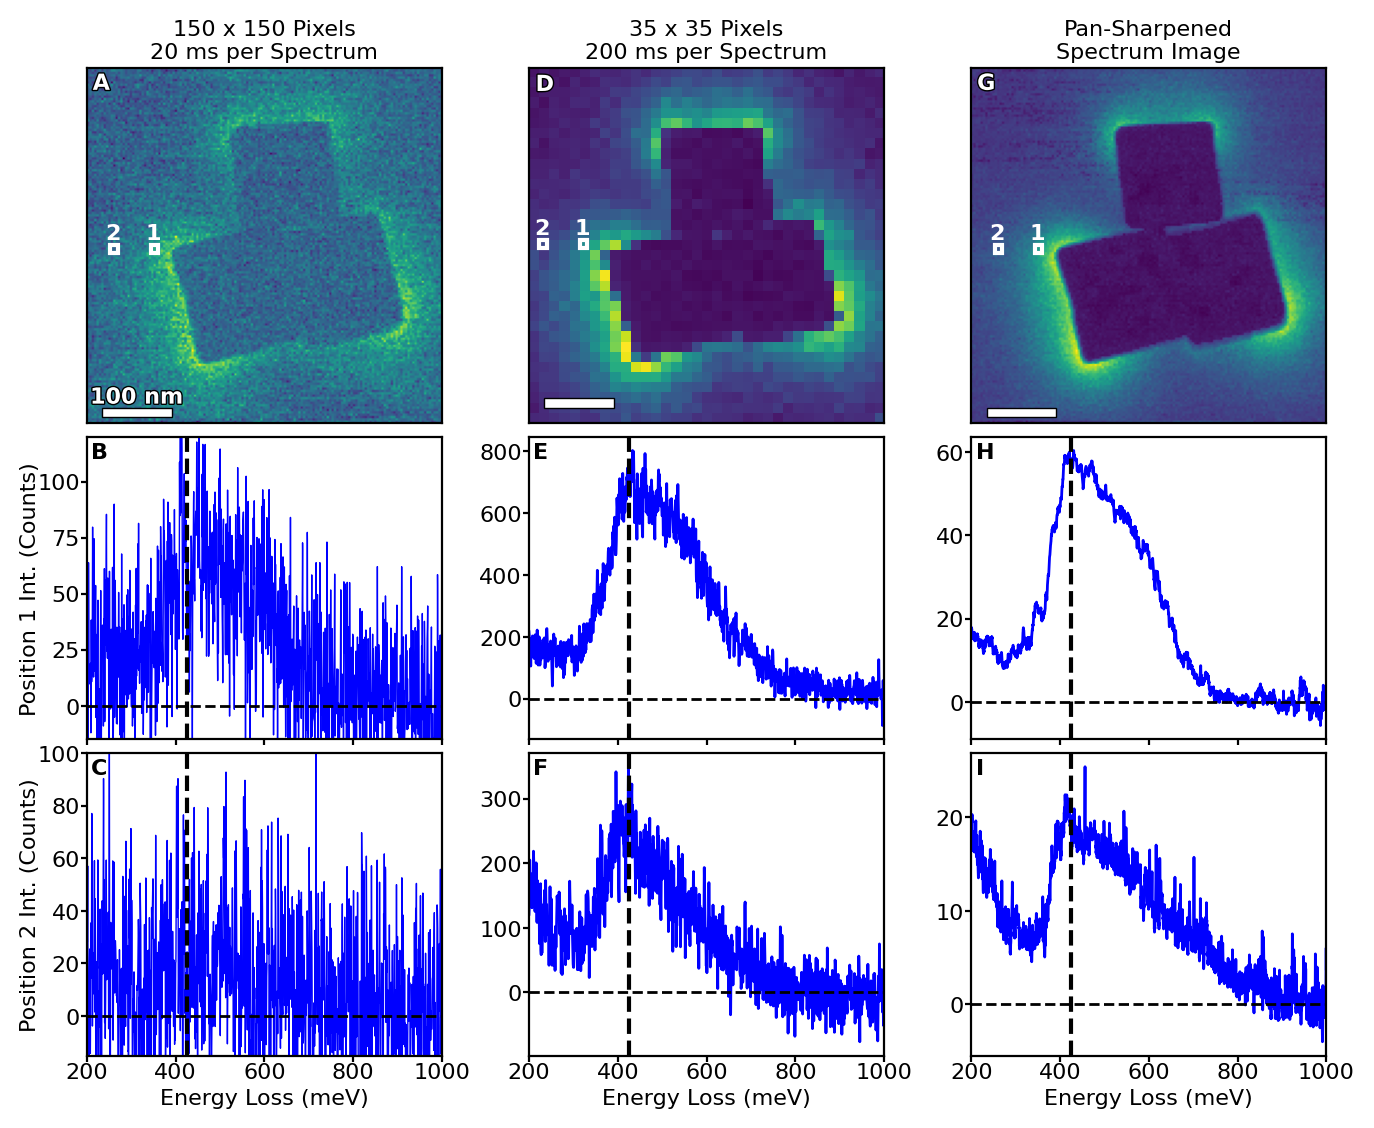

In [19]:
#@title Visualize: Pan-Sharpened Dataset

# Set energy value for energy-filtered slices of hyperspectral datasets
E_slice=0.425
i_slice=np.argmin(np.abs(E-E_slice))

# Set pixel values for comparison
R1_pix=27,75
R2_pix=10,75

w,h=6.7,5.5;wh=w/h
fig=plt.figure(figsize=(w,h),dpi=200)

#Plot HSR Slice
ax=fig.add_axes([0.055,0.63,0.265,0.265*wh],xticks=[],yticks=[])
ax.imshow(HSR[:,:,i_slice])
ax.add_patch(Rectangle((R1_pix[0]-0.5,R1_pix[1]-0.5),3,3,fc='None',ec='w',lw=1.5))
ax.add_patch(Rectangle((R2_pix[0]-0.5,R2_pix[1]-0.5),3,3,fc='None',ec='w',lw=1.5))
ax.text(R1_pix[0]+0.5,R1_pix[1]-1.5,'1',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.text(R2_pix[0]+0.5,R2_pix[1]-1.5,'2',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.add_patch(Rectangle((6,143),100/HSR_cal,4,fc='w',ec='k',lw=0.5))
txt=ax.text(6+50/HSR_cal,143,'100 nm',color='w',fontweight='bold',fontsize=8,ha='center',va='bottom')
txt.set_path_effects([path_effects.withStroke(linewidth=1, foreground='k')])
ax.set_title('150 x 150 Pixels\n20 ms per Spectrum',fontsize=8,y=0.98)
txt=ax.text(2,2,'A',color='w',fontweight='bold',fontsize=8,ha='left',va='top')
txt.set_path_effects([path_effects.withStroke(linewidth=1,foreground='k')])

#Plot HSR Slice
ax=fig.add_axes([0.385,0.63,0.265,0.265*wh],xticks=[],yticks=[])
ax.imshow(HSF[:,:,i_slice])
R1_pix_HSF=int(R1_pix[0]*HSR_cal/HSF_cal)-1,int(R1_pix[1]*HSR_cal/HSF_cal)
R2_pix_HSF=int(R2_pix[0]*HSR_cal/HSF_cal)-1,int(R2_pix[1]*HSR_cal/HSF_cal)
ax.add_patch(Rectangle((R1_pix_HSF[0]-0.5,R1_pix_HSF[1]-0.5),0.75,0.75,fc='None',ec='w',lw=1.5))
ax.add_patch(Rectangle((R2_pix_HSF[0]-0.5,R2_pix_HSF[1]-0.5),0.75,0.75,fc='None',ec='w',lw=1.5))
ax.text(R1_pix_HSF[0]-0.25,R1_pix_HSF[1]-.75,'1',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.text(R2_pix_HSF[0]-0.25,R2_pix_HSF[1]-.75,'2',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.add_patch(Rectangle((1,32),100/HSF_cal,1,fc='w',ec='k',lw=0.5))
ax.set_title('35 x 35 Pixels\n200 ms per Spectrum',fontsize=8,y=0.98)
txt=ax.text(0.15,0.2,'D',color='w',fontweight='bold',fontsize=8,ha='left',va='top')
txt.set_path_effects([path_effects.withStroke(linewidth=1,foreground='k')])

#Plot PS Slice
ax=fig.add_axes([0.715,0.63,0.265,0.265*wh],xticks=[],yticks=[])
ax.imshow(PS[:,:,i_slice])
ax.add_patch(Rectangle((R1_pix[0]-0.5,R1_pix[1]-0.5),3,3,fc='None',ec='w',lw=1.5))
ax.add_patch(Rectangle((R2_pix[0]-0.5,R2_pix[1]-0.5),3,3,fc='None',ec='w',lw=1.5))
ax.text(R1_pix[0]+0.5,R1_pix[1]-1.5,'1',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.text(R2_pix[0]+0.5,R2_pix[1]-1.5,'2',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.add_patch(Rectangle((6,143),100/HSR_cal,4,fc='w',ec='k',lw=0.5))
ax.set_title('Pan-Sharpened\nSpectrum Image',fontsize=8,y=0.98)
txt=ax.text(2,2,'G',color='w',fontweight='bold',fontsize=8,ha='left',va='top')
txt.set_path_effects([path_effects.withStroke(linewidth=1,foreground='k')])

#Plot HSR Representative Spectrum
ax=fig.add_axes([0.055,0.3425,0.265,0.275])
ax.plot(E*1000,HSR[R1_pix[1],R1_pix[0]],color='b',lw=0.5)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.set_ylabel('Position 1 Int. (Counts)',fontsize=8,labelpad=-1)
ax.set_ylim(-15,120)
ax.text(E[0]*1000+10,ax.get_ylim()[1]*0.98,'B',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')
ax.set_xticklabels([])

ax=fig.add_axes([0.055,0.055,0.265,0.275])
ax.plot(E*1000,HSR[R2_pix[1],R2_pix[0]],color='b',lw=0.5)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=2)
ax.set_ylabel('Position 2 Int. (Counts)',fontsize=8,labelpad=-1)
ax.set_ylim(-15,100)
ax.text(E[0]*1000+10,ax.get_ylim()[1]*0.98,'C',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')

#Plot HSF Representative Spectrum
ax=fig.add_axes([0.385,0.3425,0.265,0.275])
ax.plot(E*1000,HSF[R1_pix_HSF[1],R1_pix_HSF[0]],color='b',lw=1)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.text(E[0]*1000+10,ax.get_ylim()[1]*0.98,'E',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')
ax.set_xticklabels([])

ax=fig.add_axes([0.385,0.055,0.265,0.275])
ax.plot(E*1000,HSF[R2_pix_HSF[1],R2_pix_HSF[0]],color='b',lw=1)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.text(E[0]*1000+10,ax.get_ylim()[1]*0.98,'F',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')
ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=2)

#Plot PS Representative Spectrum
ax=fig.add_axes([0.715,0.3425,0.265,0.275])
ax.plot(E*1000,PS[R1_pix[1],R1_pix[0]],color='b',lw=1)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=2)
ax.text(E[0]*1000+10,ax.get_ylim()[1]*0.98,'H',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')
ax.set_xticklabels([])

ax=fig.add_axes([0.715,0.055,0.265,0.275])
ax.plot(E*1000,PS[R2_pix[1],R2_pix[0]],color='b',lw=1)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=2)
ax.text(E[0]*1000+10,ax.get_ylim()[1]*0.98,'I',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')